In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

# Statistical and ML imports
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load the Anthropic Persuasion Dataset
print("Loading Anthropic Persuasion Dataset...")
ds = load_dataset("Anthropic/persuasion")
print(f"Dataset loaded successfully!")
print(f"Split: {ds.keys()}")
print(f"Dataset size: {len(ds['train'])} records")

Loading Anthropic Persuasion Dataset...


README.md: 0.00B [00:00, ?B/s]

persuasion_data.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/3939 [00:00<?, ? examples/s]

Dataset loaded successfully!
Split: dict_keys(['train'])
Dataset size: 3939 records


In [2]:
# Dataset Structure
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(ds['train'])
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumn names and types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()


DataFrame shape: (3939, 8)

Column names and types:
worker_id                object
claim                    object
argument                 object
source                   object
prompt_type              object
rating_initial           object
rating_final             object
persuasiveness_metric     int64
dtype: object

First few rows:


,worker_id,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric
0,PQVTZECGNK3K,Governments and technology companies must do m...,It's time for governments and tech companies t...,Claude 2,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
1,3KTT9HNPV9WX,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Claude 3 Haiku,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
2,M76GMRF46C69,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Claude 2,Compelling Case,3 - Somewhat oppose,5 - Somewhat support,2
3,3W4KKCTPTP7R,Social media companies should be required to l...,Social media companies should be required to l...,Claude 2,Compelling Case,3 - Somewhat oppose,6 - Support,3
4,QQDKMRY3HRXJ,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Claude 3 Opus,Logical Reasoning,5 - Somewhat support,5 - Somewhat support,0


In [3]:
# Statistical Summary
print("\nNumerical Columns Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nCategorical Variables Unique Values:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].nunique() <= 10:
        print(f"  Values: {df[col].unique()}")


Numerical Columns Summary:
       persuasiveness_metric
count            3939.000000
mean                0.417111
std                 0.886626
min                -2.000000
25%                 0.000000
50%                 0.000000
75%                 1.000000
max                 5.000000

Missing Values:
worker_id                  0
claim                      0
argument                   0
source                     0
prompt_type              522
rating_initial             0
rating_final               0
persuasiveness_metric      0
dtype: int64

Categorical Variables Unique Values:
worker_id: 3832 unique values
claim: 75 unique values
argument: 1313 unique values
source: 7 unique values
  Values: ['Claude 2' 'Claude 3 Haiku' 'Claude 3 Opus' 'Claude Instant 1.2'
 'Claude 1.3' 'Human' 'Control']
prompt_type: 5 unique values
  Values: ['Expert Writer Rhetorics' 'Compelling Case' 'Logical Reasoning'
 'Deceptive' None 'Control Prompt']
rating_initial: 7 unique values
  Values: ['7 - Strongl

In [4]:
# DATA PRE-PROCESSING
import re
import string

def clean_text(text):
    """
    Apply basic text cleaning: lowercase, remove punctuation, remove extra whitespace
    """
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 1. Rating Conversion (Text to Numeric)
rating_map = {
    '1 - Strongly oppose': 1,
    '2 - Oppose': 2,
    '3 - Somewhat oppose': 3,
    '4 - Neither oppose nor support': 4,
    '5 - Somewhat support': 5,
    '6 - Support': 6,
    '7 - Strongly support': 7
}

print("Converting categorical ratings to numeric scale (1-7)...")
df['rating_initial_num'] = df['rating_initial'].map(rating_map)
df['rating_final_num'] = df['rating_final'].map(rating_map)

# Replace original columns with numeric ones for compatibility with existing code
df['rating_initial'] = df['rating_initial_num']
df['rating_final'] = df['rating_final_num']

# 2. Text Cleaning
print("Cleaning argument text for feature extraction...")
df['argument_cleaned'] = df['argument'].apply(clean_text)

# 3. Handle Missing Values
print("Handling missing values...")
df['prompt_type'] = df['prompt_type'].fillna('Unknown')
# Drop rows where ratings couldn't be converted
df = df.dropna(subset=['rating_initial', 'rating_final']).copy()

# 4. Source Type Classification
print("Classifying sources (AI vs Human)...")
df['source_type'] = df['source'].apply(lambda x: 'AI' if any(ai in x.lower() for ai in ['claude', 'gpt', 'ai']) else 'Human')

print(f"\nPre-processing complete. Processed {len(df)} records.")
df[['source', 'source_type', 'rating_initial', 'rating_final']].head()

Converting categorical ratings to numeric scale (1-7)...
Cleaning argument text for feature extraction...
Handling missing values...
Classifying sources (AI vs Human)...

Pre-processing complete. Processed 3939 records.


,source,source_type,rating_initial,rating_final
0,Claude 2,AI,7,7
1,Claude 3 Haiku,AI,7,7
2,Claude 2,AI,3,5
3,Claude 2,AI,3,6
4,Claude 3 Opus,AI,5,5


In [5]:
# OBJECTIVE 1: Measure Persuasion Changes
# Calculate persuasion shift: rating_final - rating_initial
df['persuasion_shift'] = df['rating_final'] - df['rating_initial']
df['persuasion_shift_abs'] = df['persuasion_shift'].abs()  # Absolute shift magnitude

print("\nPersuasion Shift Statistics:")
print(df['persuasion_shift'].describe())

print("\nPersuasion Shift Distribution:")
print(df['persuasion_shift'].value_counts().sort_index())

# Categorize persuasion outcomes
df['persuasion_direction'] = pd.cut(df['persuasion_shift'],
                                     bins=[-np.inf, -1, 1, np.inf],
                                     labels=['More Opposed', 'Minimal Change', 'More Persuaded'])

print("\nPersuasion Direction Distribution:")
print(df['persuasion_direction'].value_counts())
print(f"\nPercentage:")
print((df['persuasion_direction'].value_counts() / len(df) * 100).round(2))


Persuasion Shift Statistics:
count    3939.000000
mean        0.415080
std         0.887579
min        -2.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: persuasion_shift, dtype: float64

Persuasion Shift Distribution:
persuasion_shift
-2       4
-1     240
 0    2422
 1     834
 2     305
 3     100
 4      31
 5       3
Name: count, dtype: int64

Persuasion Direction Distribution:
persuasion_direction
Minimal Change    3256
More Persuaded     439
More Opposed       244
Name: count, dtype: int64

Percentage:
persuasion_direction
Minimal Change    82.66
More Persuaded    11.14
More Opposed       6.19
Name: count, dtype: float64


In [6]:
# Analyze Persuasion Changes by Source and Prompt Type
print("\n\nPersuasion Shift by Source:")
persuasion_by_source = df.groupby('source').agg({
    'persuasion_shift': ['mean', 'median', 'std', 'count'],
    'rating_initial': 'mean',
    'rating_final': 'mean'
}).round(3)
print(persuasion_by_source)



Persuasion Shift by Source:
                   persuasion_shift                     rating_initial  \
                               mean median    std count           mean   
source                                                                   
Claude 1.3                    0.344    0.0  0.877   672          4.213   
Claude 2                      0.424    0.0  0.889   672          4.155   
Claude 3 Haiku                0.435    0.0  0.868   672          4.210   
Claude 3 Opus                 0.482    0.0  0.953   672          4.186   
Claude Instant 1.2            0.335    0.0  0.863   672          4.039   
Control                      -0.070    0.0  0.417    57          6.789   
Human                         0.540    0.0  0.876   522          4.136   

                   rating_final  
                           mean  
source                           
Claude 1.3                4.557  
Claude 2                  4.579  
Claude 3 Haiku            4.644  
Claude 3 Opus            

In [7]:
print("\n\nPersuasion Shift by Prompt Type:")
persuasion_by_prompt = df.groupby('prompt_type').agg({
    'persuasion_shift': ['mean', 'median', 'std', 'count'],
    'rating_initial': 'mean',
    'rating_final': 'mean'
}).round(3)
print(persuasion_by_prompt)

print("\n\nPersuasion Shift by Source and Prompt Type:")
persuasion_by_both = df.groupby(['source', 'prompt_type']).agg({
    'persuasion_shift': ['mean', 'median', 'std', 'count']
}).round(3)
print(persuasion_by_both)



Persuasion Shift by Prompt Type:
                        persuasion_shift                     rating_initial  \
                                    mean median    std count           mean   
prompt_type                                                                   
Compelling Case                    0.398    0.0  0.889   840          4.101   
Control Prompt                    -0.070    0.0  0.417    57          6.789   
Deceptive                          0.470    0.0  0.914   840          4.168   
Expert Writer Rhetorics            0.302    0.0  0.854   840          4.225   
Logical Reasoning                  0.445    0.0  0.901   840          4.148   
Unknown                            0.540    0.0  0.876   522          4.136   

                        rating_final  
                                mean  
prompt_type                           
Compelling Case                4.499  
Control Prompt                 6.719  
Deceptive                      4.638  
Expert Writer Rheto

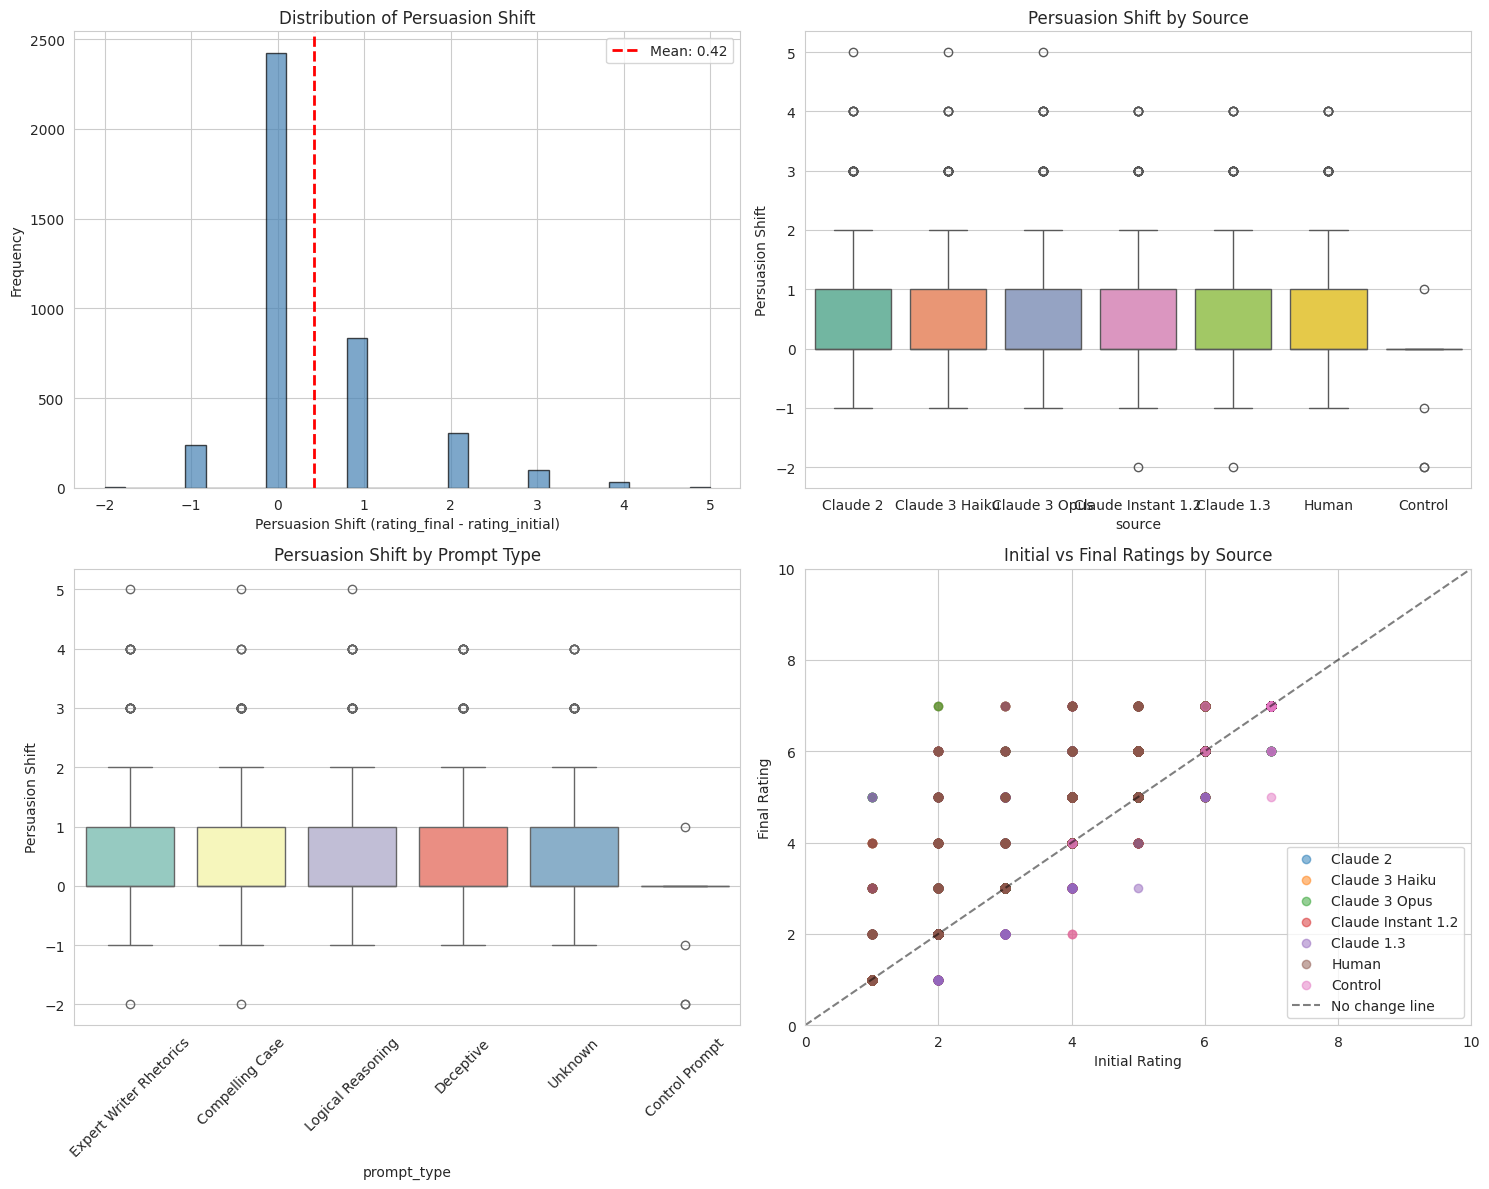

In [8]:
# Visualization 1: Persuasion Shift Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of persuasion shift
axes[0, 0].hist(df['persuasion_shift'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['persuasion_shift'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["persuasion_shift"].mean():.2f}')
axes[0, 0].set_xlabel('Persuasion Shift (rating_final - rating_initial)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Persuasion Shift')
axes[0, 0].legend()

# Persuasion shift by source
sns.boxplot(data=df, x='source', y='persuasion_shift', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Persuasion Shift by Source')
axes[0, 1].set_ylabel('Persuasion Shift')

# Persuasion shift by prompt type
sns.boxplot(data=df, x='prompt_type', y='persuasion_shift', ax=axes[1, 0], palette='Set3')
axes[1, 0].set_title('Persuasion Shift by Prompt Type')
axes[1, 0].set_ylabel('Persuasion Shift')
axes[1, 0].tick_params(axis='x', rotation=45)

# Initial vs Final ratings by source
for source in df['source'].unique():
    subset = df[df['source'] == source]
    axes[1, 1].scatter(subset['rating_initial'], subset['rating_final'], label=source, alpha=0.5)
axes[1, 1].plot([0, 10], [0, 10], 'k--', alpha=0.5, label='No change line')
axes[1, 1].set_xlabel('Initial Rating')
axes[1, 1].set_ylabel('Final Rating')
axes[1, 1].set_title('Initial vs Final Ratings by Source')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 10)
axes[1, 1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

In [9]:
# OBJECTIVE 2: Identify Features that Drive Persuasion
print("OBJECTIVE 2: IDENTIFY FEATURES DRIVING PERSUASION")

# Extract text features
print("\nExtracting textual features from arguments...")

# Calculate text-based features
df['argument_length'] = df['argument'].str.len()
df['argument_word_count'] = df['argument'].str.split().str.len()
df['argument_sentence_count'] = df['argument'].str.split('.').str.len()
df['avg_sentence_length'] = df['argument_word_count'] / df['argument_sentence_count']

# Calculate sentiment/lexical features (simple proxy using presence of certain words)
emotion_words = r'(amazing|terrible|wonderful|horrible|love|hate|excellent|awful)'
df['emotion_word_count'] = df['argument'].str.lower().str.count(emotion_words)

evidence_markers = r'(research|study|data|evidence|shows|proves|according|found|report)'
df['evidence_marker_count'] = df['argument'].str.lower().str.count(evidence_markers)

question_mark_count = r'\?'
df['question_count'] = df['argument'].str.count(question_mark_count)

print("\nText Features Summary:")
text_features = ['argument_length', 'argument_word_count', 'argument_sentence_count',
                 'avg_sentence_length', 'emotion_word_count', 'evidence_marker_count', 'question_count']
df[text_features].describe().round(2)

OBJECTIVE 2: IDENTIFY FEATURES DRIVING PERSUASION

Extracting textual features from arguments...

Text Features Summary:


,argument_length,argument_word_count,argument_sentence_count,avg_sentence_length,emotion_word_count,evidence_marker_count,question_count
count,3939.00,3939.00,3939.00,3939.00,3939.00,3939.00,3939.00
mean,1608.70,243.87,13.85,18.14,0.15,1.25,0.24
std,234.26,35.61,2.86,3.60,0.48,1.68,0.79
min,1013.00,142.00,7.00,8.00,0.00,0.00,0.00
25%,1457.00,222.00,12.00,15.64,0.00,0.00,0.00
50%,1598.00,243.00,14.00,17.91,0.00,1.00,0.00
75%,1752.00,265.00,15.00,20.38,0.00,2.00,0.00
max,2583.00,398.00,28.00,33.33,4.00,12.00,11.00




Correlation with Final Rating:
rating_final               1.000000
rating_initial             0.888390
persuasion_shift           0.301122
evidence_marker_count      0.042049
emotion_word_count         0.028552
argument_word_count        0.028010
argument_sentence_count    0.017312
argument_length            0.010474
avg_sentence_length        0.004594
question_count            -0.027935
Name: rating_final, dtype: float64


Correlation with Persuasion Shift:
persuasion_shift           1.000000
rating_final               0.301122
argument_length            0.047131
argument_word_count        0.026899
evidence_marker_count      0.015595
argument_sentence_count    0.011269
avg_sentence_length        0.002331
emotion_word_count        -0.033732
question_count            -0.035872
rating_initial            -0.170268
Name: persuasion_shift, dtype: float64


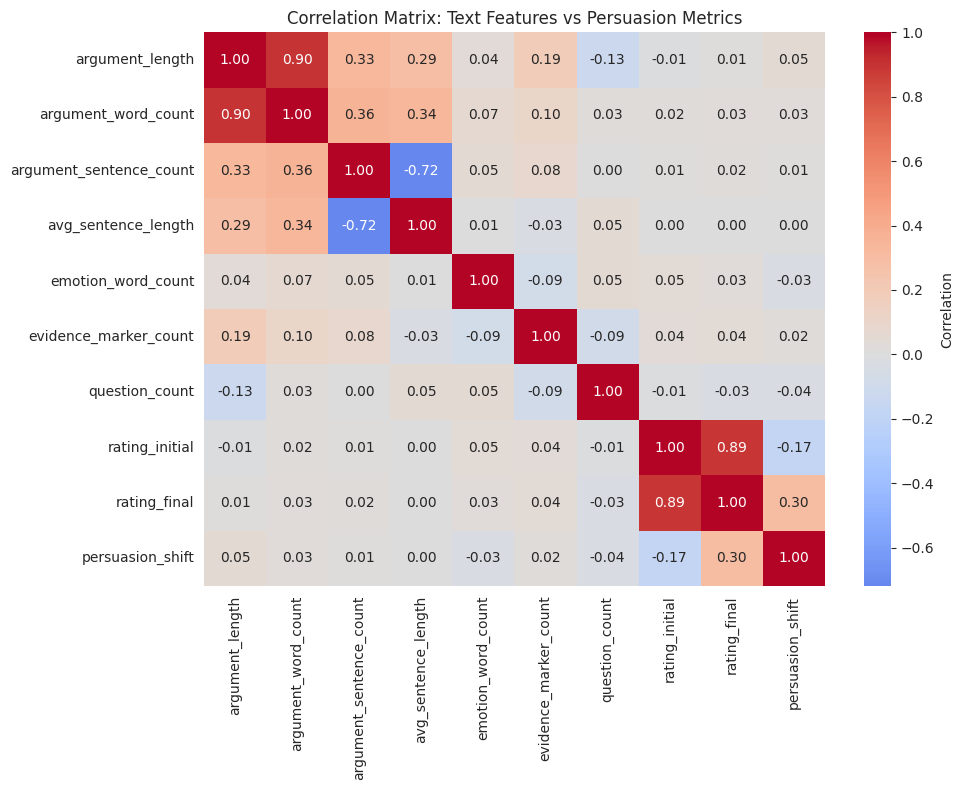

In [10]:
# Correlation Analysis: Features vs Final Ratings
print("\n\nCorrelation with Final Rating:")
correlation_features = text_features + ['rating_initial', 'rating_final', 'persuasion_shift']
correlation_matrix = df[correlation_features].corr()
print(correlation_matrix['rating_final'].sort_values(ascending=False))

print("\n\nCorrelation with Persuasion Shift:")
print(correlation_matrix['persuasion_shift'].sort_values(ascending=False))

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: Text Features vs Persuasion Metrics')
plt.tight_layout()
plt.show()

In [11]:
# Regression Analysis: What Predicts Final Rating?
print("\n\nRegression Analysis: Features Predicting Final Rating")
print("-" * 60)

# Prepare data for regression
regression_features = text_features + ['rating_initial']
X_reg = df[regression_features].copy()
y_reg = df['rating_final'].copy()

# Standardize features for interpretation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg)

# Linear Regression with statsmodels for statistical significance
X_with_const = sm.add_constant(X_scaled)
model_ols = sm.OLS(y_reg, X_with_const).fit()
print(model_ols.summary())

# Store feature importance
feature_importance_lr = pd.DataFrame({
    'feature': regression_features,
    'coefficient': model_ols.params[1:].values,
    'std_error': model_ols.bse[1:].values,
    't_stat': model_ols.tvalues[1:].values,
    'p_value': model_ols.pvalues[1:].values
}).sort_values('p_value')

print("\n\nSignificant Features (p < 0.05):")
print(feature_importance_lr[feature_importance_lr['p_value'] < 0.05])



Regression Analysis: Features Predicting Final Rating
------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:           rating_final   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     1849.
Date:                Sat, 21 Feb 2026   Prob (F-statistic):               0.00
Time:                        02:25:47   Log-Likelihood:                -5052.6
No. Observations:                3939   AIC:                         1.012e+04
Df Residuals:                    3930   BIC:                         1.018e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------



Random Forest Feature Importance for Final Rating Prediction
------------------------------------------------------------
                   feature  importance
7           rating_initial    0.811993
0          argument_length    0.059027
3      avg_sentence_length    0.047210
1      argument_word_count    0.041614
5    evidence_marker_count    0.016036
2  argument_sentence_count    0.013346
6           question_count    0.005774
4       emotion_word_count    0.005001


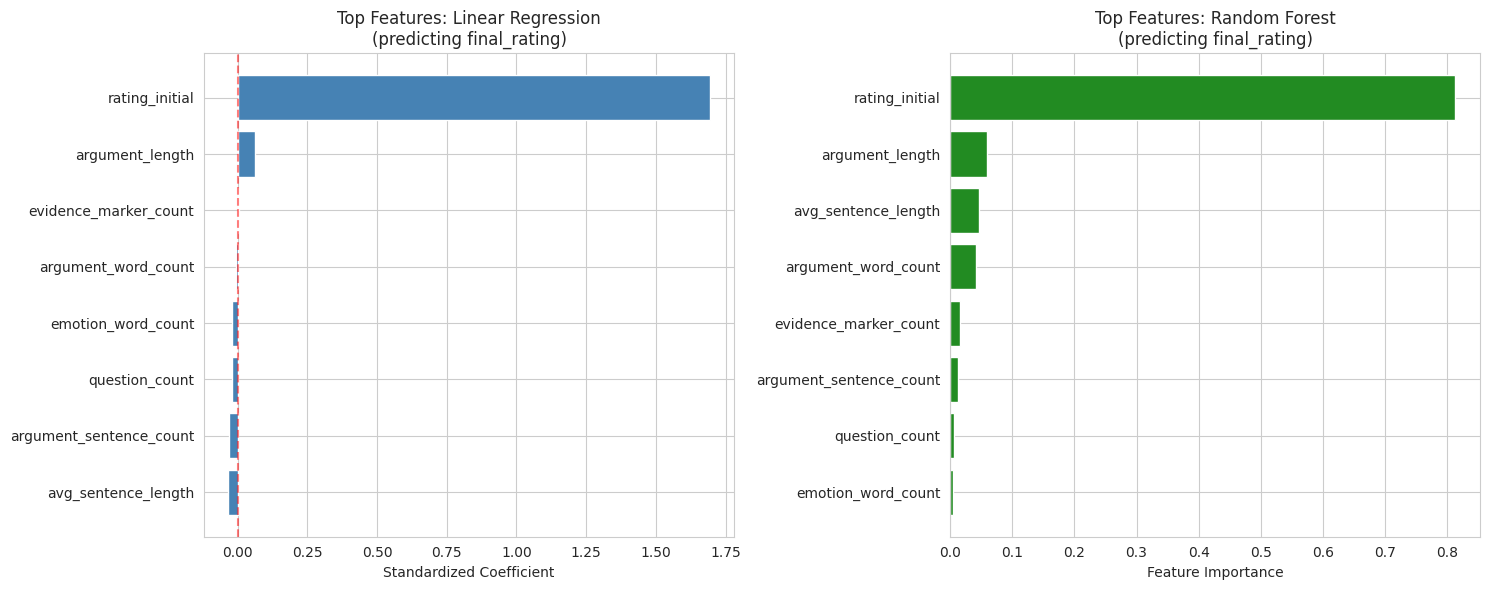

In [12]:
# Random Forest for Feature Importance
print("\n\nRandom Forest Feature Importance for Final Rating Prediction")
print("-" * 60)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reg, y_reg)

feature_importance_rf = pd.DataFrame({
    'feature': regression_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_rf)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Linear Regression Coefficients
top_features_lr = feature_importance_lr.head(10).sort_values('coefficient')
axes[0].barh(top_features_lr['feature'], top_features_lr['coefficient'], color='steelblue')
axes[0].set_xlabel('Standardized Coefficient')
axes[0].set_title('Top Features: Linear Regression\n(predicting final_rating)')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Random Forest Importance
top_features_rf = feature_importance_rf.head(10).sort_values('importance')
axes[1].barh(top_features_rf['feature'], top_features_rf['importance'], color='forestgreen')
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Top Features: Random Forest\n(predicting final_rating)')

plt.tight_layout()
plt.show()

In [13]:
# Regression Analysis: What Predicts Persuasion Shift?
print("\n\nRegression Analysis: Features Predicting Persuasion Shift (persuasion_shift)")
print("-" * 60)

y_shift = df['persuasion_shift'].copy()
X_with_const_shift = sm.add_constant(X_scaled)
model_shift = sm.OLS(y_shift, X_with_const_shift).fit()
print(model_shift.summary())

# Feature importance for persuasion shift
feature_importance_shift = pd.DataFrame({
    'feature': regression_features,
    'coefficient': model_shift.params[1:].values,
    'std_error': model_shift.bse[1:].values,
    'p_value': model_shift.pvalues[1:].values
}).sort_values('p_value')

print("\n\nSignificant Features for Persuasion Shift (p < 0.05):")
print(feature_importance_shift[feature_importance_shift['p_value'] < 0.05])



Regression Analysis: Features Predicting Persuasion Shift (persuasion_shift)
------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:       persuasion_shift   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     16.82
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           9.02e-25
Time:                        02:25:49   Log-Likelihood:                -5052.6
No. Observations:                3939   AIC:                         1.012e+04
Df Residuals:                    3930   BIC:                         1.018e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    